In [1]:
import networkx as nx 
import torch 
from torch_geometric.utils import to_dense_adj

Three cliques


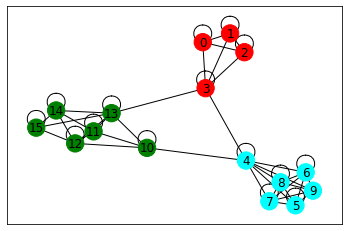

In [10]:
c1_c2 = torch.tensor([
    [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3, 3,4,4,10,  4,4,4,4,4,5,5,5,5,5,6,6,6,6,6,7,7,7,7,7,8,8,8,8,8,9,9,9,9,9],
    [0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3, 4,3,10,4,  4,5,6,7,8,4,5,6,7,8,4,5,6,7,8,4,5,6,7,8,4,5,6,7,8,4,5,6,7,8]
])
c3 = torch.tensor([
    [10,10,10,10, 11,11,11,11,11, 12,12,12,12,12,12, 13,13,13,13,13,13, 14,14,14,14,14, 15,15,15,15, 13, 3],
    [11,12,13,10, 11,10,12,13,14, 12,11,10,13,14,15, 13,10,11,12,14,15, 14,12,13,15,11, 15,12,13,14, 3, 13]
])

ei = torch.cat([c1_c2, c3], dim=1)
adj = to_dense_adj(ei)[0]
g = nx.from_numpy_matrix(adj.numpy())

colors = ['red']*4 + ['cyan']*6 + ['green']*6
labels = torch.tensor([0]*4 + [1]*6 + [2]*6)

nx.draw_networkx(g, node_color=colors)
print("Three cliques")

In [27]:
def sssp_to_torch(sssp):
    # I hate nx so fucking much
    sssp = [s for s in sssp]
    n = max(sssp, key=lambda x : x[0])[0] + 1
    m = torch.full((n,n), -1)

    for src, dists in sssp: 
        for dst,dist in dists.items():
            m[src][dst] = dist

    return m 

sssp = nx.shortest_path_length(g)
orig = sssp_to_torch(sssp)

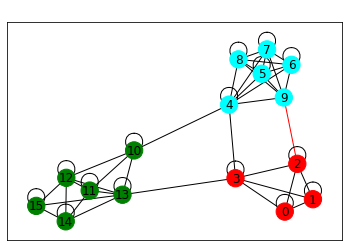

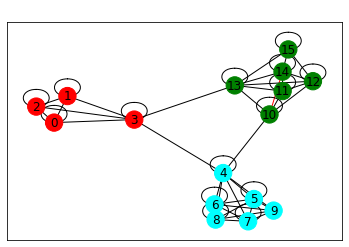

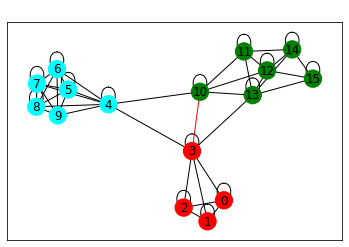

In [37]:
import matplotlib.pyplot as plt 

# Add anomalous edge between cliques
g.add_edge(9,2, color='red')
plt.title('Anomalous', color='white')
edge_colors = [g[u][v].get('color', 'black') for u,v in g.edges()]
nx.draw_networkx(g, node_color=colors, edge_color=edge_colors)
plt.show()
anom = sssp_to_torch(nx.shortest_path_length(g))

# Add benign edge within clique 
g.remove_edge(9,2)
g.add_edge(10,14, color='red')
plt.title('Benign', color='white')
edge_colors = [g[u][v].get('color', 'black') for u,v in g.edges()]
nx.draw_networkx(g, node_color=colors, edge_color=edge_colors)
plt.show()
benign = sssp_to_torch(nx.shortest_path_length(g))

# Add maybe anom edge between clique boarders 
g.remove_edge(10,14)
g.add_edge(3,10, color='red')
plt.title('Unclear', color='white')
edge_colors = [g[u][v].get('color', 'black') for u,v in g.edges()]
nx.draw_networkx(g, node_color=colors, edge_color=edge_colors)
plt.show()
benign = sssp_to_torch(nx.shortest_path_length(g))

g.remove_edge(3,10)

In [49]:
def norm(m1,m2): return (m1.float()-m2.float()).pow(2).mean()
def tot(m1,m2): return (m1.float()-m2.float()).pow(2).sum()

def frob(m1,m2):
    m = m1.float() - m2.float()
    mT = m1.float() - m2.T.float()
    return torch.trace(m * mT).pow(1/2)

print("L2")
print("\tAnom:\t", norm(orig, anom))
print("\tBenign:\t", norm(orig, benign))
print("\tUnclear:", norm(orig, unk))

print("Sum L2")
print("\tAnom:\t", tot(orig, anom))
print("\tBenign:\t", tot(orig, benign))
print("\tUnclear:", tot(orig, unk))

print("Frobenius (too sparse?)")
print("\tAnom:\t", frob(orig, anom))
print("\tBenign:\t", frob(orig, benign))
print("\tUnclear:", frob(orig, unk))



L2
	Anom:	 tensor(0.0781)
	Benign:	 tensor(0.0312)
	Unclear: tensor(0.0312)
Sum L2
	Anom:	 tensor(20.)
	Benign:	 tensor(8.)
	Unclear: tensor(8.)
Frobenius (too sparse?)
	Anom:	 tensor(0.)
	Benign:	 tensor(0.)
	Unclear: tensor(0.)
